In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib widget

In [3]:
#%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
from datetime import datetime, timedelta
from ipywidgets import interact
# from datetime import datetime as dt, time, timedelta

In [4]:
import sys
import os
from os.path import join
import re
import cv2

from tqdm.notebook import tqdm
# Test
for i in tqdm(range(50)):
    pass

In [5]:
# Try to import plotbee from local git clone
# Alternative would be: 
# cd .../plotbee
# pip install -e .   (install local directory editable mode)
module_path = os.path.abspath(os.path.join('..'))
print(f'ADDING "{module_path}" to path for import')
sys.path.insert(0,module_path)
sys.path.remove('/mnt/storage/work/rmegret/plotbee')
print('PATH=',sys.path)

ADDING "/home/rmegret/plotbee" to path for import
PATH= ['/home/rmegret/plotbee', '/home/rmegret/plotbee/notebooks', '/home/rmegret/anaconda3/envs/videomgr/lib/python37.zip', '/home/rmegret/anaconda3/envs/videomgr/lib/python3.7', '/home/rmegret/anaconda3/envs/videomgr/lib/python3.7/lib-dynload', '', '/home/rmegret/anaconda3/envs/videomgr/lib/python3.7/site-packages', '/home/jchan/plotbee/apriltag', '/home/rmegret/beeutils/SlurmQueen', '/home/rmegret/anaconda3/envs/videomgr/lib/python3.7/site-packages/locket-0.2.1-py3.7.egg', '/home/rmegret/anaconda3/envs/videomgr/lib/python3.7/site-packages/IPython/extensions', '/home/rmegret/.ipython']


In [6]:
from plotbee.beevideoutil import labelbee_convert as lb
from plotbee.beevideoutil import video as bv
import plotbee
print(f'plotbee imported from "{plotbee.__file__}"')

plotbee imported from "/home/rmegret/plotbee/plotbee/__init__.py"


/home/rmegret/plotbee/plotbee/beevideoutil/labelbee_convert.py:316: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
from decord import VideoReader
from decord import cpu, gpu

def get_video_date(filename):
    pattern  = r"C(?P<colony>[0-9][0-9])_(?P<year>[0-9][0-9])(?P<month>[0-9][0-9])(?P<day>[0-9][0-9])(?P<hour>[0-9][0-9])(?P<min>[0-9][0-9])(?P<sec>[0-9][0-9])"
    pattern = re.compile(pattern)
    m = pattern.search(filename)
    date_format = ["year", "month", "day", "hour", "min", "sec"]

    YY,MM,DD,hh,mm,ss=[int(m.group(g)) for g in date_format]
    return datetime(2000+YY,MM,DD,hh,mm,ss)

def one_hot_encoding(df, columns=[]):
    cdf = df.copy()
    if isinstance(columns, list):
        for c in columns:
            cdf = one_hot_encode_column(cdf, c)
    elif isinstance(columns, str):
        cdf = one_hot_encode_column(cdf, columns)
    return cdf
  
def one_hot_encode_column(df, column):
    categories = df[column].dropna().unique()
    for cat in categories:
        df[cat] = (df[column] == cat)
    return df

def load_track_df(filename):
    track_df = pd.read_csv(filename)
    starttime = get_video_date(filename)
    track_df["datetime"] = track_df.apply(lambda x: starttime + timedelta(seconds=x["track_startframe"]/20), axis=1)
    track_df["track_starttime"] = track_df.apply(lambda x: starttime + timedelta(seconds=x["track_startframe"]/20), axis=1)
    track_df["track_endtime"] = track_df.apply(lambda x: starttime + timedelta(seconds=x["track_endframe"]/20), axis=1)
    track_df["pollen"] = track_df["track_pollen_score"] > 0.5
    track_df = one_hot_encoding(track_df, columns=["track_event"])
    return track_df

def get_options(tid):
    options = list()
    for i, row in vdf[vdf.track_tagid == tid].iterrows():
        noise, name = event_name(row)
#         if not noise:
        options.append((name, dict(row)))
    return options

def event_name(row):
    noise = False
    event_name = ""
    if row.pollen:
        event_name += "pollen"
    if row.entering:
        event_name += "entering"
    if row.leaving:
        event_name += "leaving"
    if row.walking:
        event_name += "walking"
    if row.entering_leaving:
        event_name += "entering_leaving"
    if event_name == "":
        event_name += "noise"
        noise = True
        
    event_name += " - {}".format(row.datetime)
    return noise, event_name

def load_frame(video, frame, videoreader=None):
    if (videoreader is None):
        vr = VideoReader(video, ctx=cpu(0))
    else:
        vr = videoreader
    frameimg = vr[frame].asnumpy()
    
    return frameimg

def plot_line(frame, p1, p2, color=[255, 0, 0], thickness=7):
    frame = cv2.line(frame, p1, p2, color, thickness)
    return frame

def plot_track(row, frame=None, videoreader=None, ax=None):
    if (frame is None):
        frame = row["track_startframe"]
    frameimg = load_frame(row["video_name"], frame, videoreader)
    start_x = row["track_startx"] 
    start_y = row["track_starty"]
    
    end_x = row["track_endx"]
    end_y = row["track_endy"]
    
    p1 = (start_x, start_y)
    p2 = (end_x, end_y)
    
    #plt.imshow(plot_line(frameimg, p1, p2))
    if (ax is None):
        ax = plt.gca()
    ax.imshow(frameimg)
    ax.plot( (start_x,end_x), (start_y,end_y), 'r.-' )
    ax.plot( (start_x,), (start_y,), 'ro' )
    ax.plot( (end_x,), (end_y,), 'rx' )

### Optional Load raw files one by one (prefer bulk load below)

In [10]:
files = glob.glob("/mnt/storage/work/jchan/final_beepose/one_week_analysis_800/analysis_tracks*")
files = sorted(files)
files;

In [8]:
track_dfs = list()
for i, file in enumerate(tqdm(files)):
    track_df = load_track_df(file)
    track_df["video_id"] = i
    track_dfs.append(track_df)
    
full_df = pd.concat(track_dfs)

In [42]:
# Add path to video (custom)
VIDEO_FORMAT = "/mnt/storage/work/jchan/bees/tag_dataset/videos/C02_%y%m%d%H0000.mp4"
full_df.loc[:, "video_name"] = full_df.datetime.apply(lambda x: x.strftime(VIDEO_FORMAT))
# Warning: video_id is not the id in labelbee database! Just local id for processing the week

In [86]:
full_df = full_df.reset_index() # Important, have unique indices!

In [87]:
full_df.to_parquet('one_week_analysis_800__tracks__with_video_names.parquet')

In [44]:
!ls -hl one_week_analysis_800*.parquet

-rw-rw-r-- 1 rmegret rmegret 80M Mar 12 17:36 one_week_analysis_800__tracks.parquet
-rw-rw-r-- 1 rmegret rmegret 80M Mar 14 15:15 one_week_analysis_800__tracks__with_video_names.parquet


### Bulk load

In [88]:
full_df = pd.read_parquet('one_week_analysis_800__tracks__with_video_names.parquet')

In [89]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958893 entries, 0 to 1958892
Data columns (total 26 columns):
 #   Column              Dtype         
---  ------              -----         
 0   index               int64         
 1   track_id            int64         
 2   track_pollen_score  float64       
 3   track_shape         object        
 4   track_event         object        
 5   track_tagid         float64       
 6   track_hastag        bool          
 7   track_startframe    int64         
 8   track_startx        int64         
 9   track_starty        int64         
 10  track_starta        float64       
 11  track_endframe      int64         
 12  track_endx          int64         
 13  track_endy          int64         
 14  track_enda          float64       
 15  track_length        int64         
 16  datetime            datetime64[ns]
 17  track_starttime     datetime64[ns]
 18  track_endtime       datetime64[ns]
 19  pollen              bool          
 20  en

In [92]:
# Select tag ids that have 5 events or more
id_counts = full_df['track_tagid'].dropna().astype(int).value_counts().rename('counts')
tids = id_counts[id_counts>=5].index
tids = np.sort(tids).astype(int)
tids

array([ 197,  508,  515,  516,  517,  638,  661,  677,  930,  986, 1109,
       1230, 1237, 1361, 1404, 1407, 1415, 1607, 1609, 1621, 1651, 1652,
       1698, 1722, 1780, 1786, 1797, 1900, 1979, 2258, 2487])

In [91]:
# Custom tids
tids = np.array([1609,1621],dtype=int)

In [101]:
# Restrict data to selected tids
vdf = full_df[full_df.track_tagid.isin(tids)].copy()
vdf['track_tagid'] = vdf['track_tagid'].astype(int)
vdf.shape

(5024, 26)

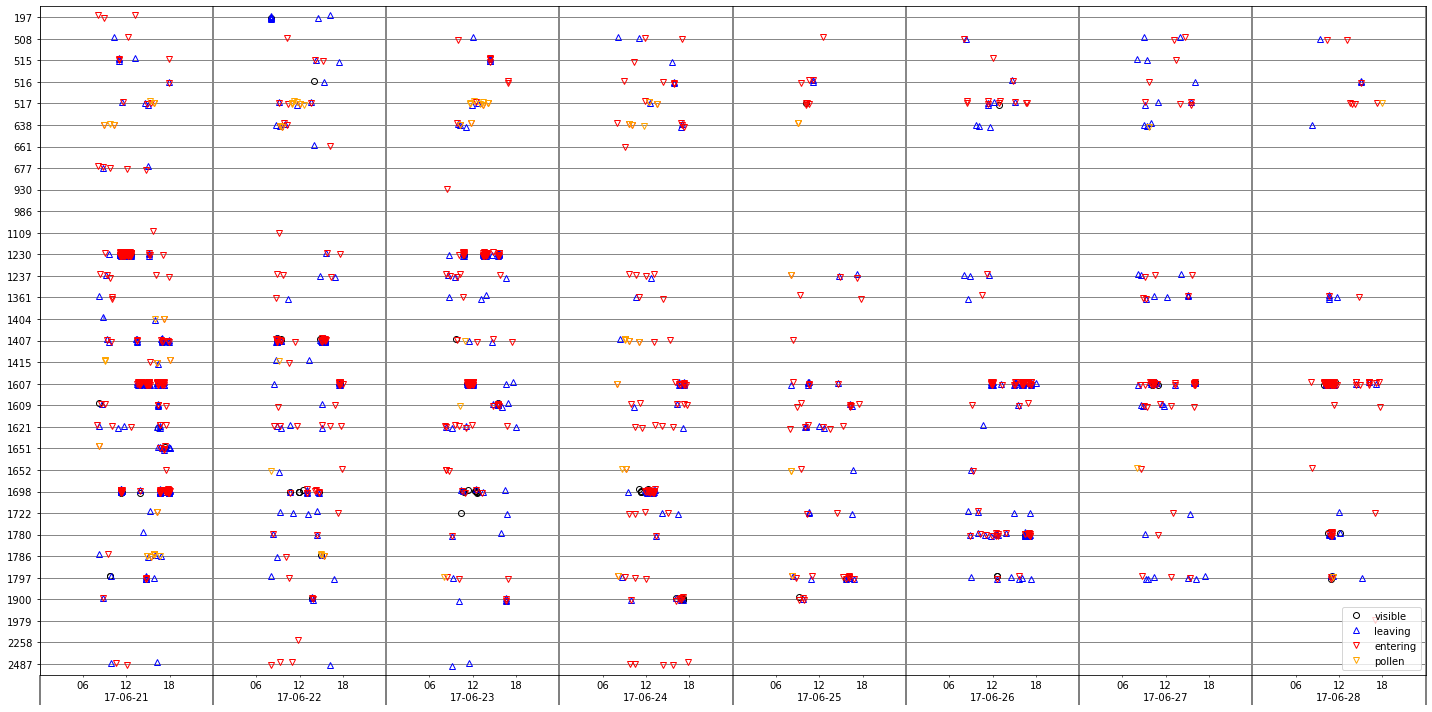

In [94]:
%matplotlib inline
from datetime import datetime as dt

fig,axes = plt.subplots(1,1,figsize=(20,10))
plt.sca(axes)
lb.plot_activities_df(vdf, plot_interval=True, tagids=None, leaving_symbol = '^', entering_symbol = 'v');
plt.tight_layout();

lb.format_multiday()
plt.xlim(pd.to_datetime('2017-06-21 00:00'),pd.to_datetime('2017-06-29 00:00'))

plt.tight_layout();

plt.savefig("tagged_bees_activities.png")

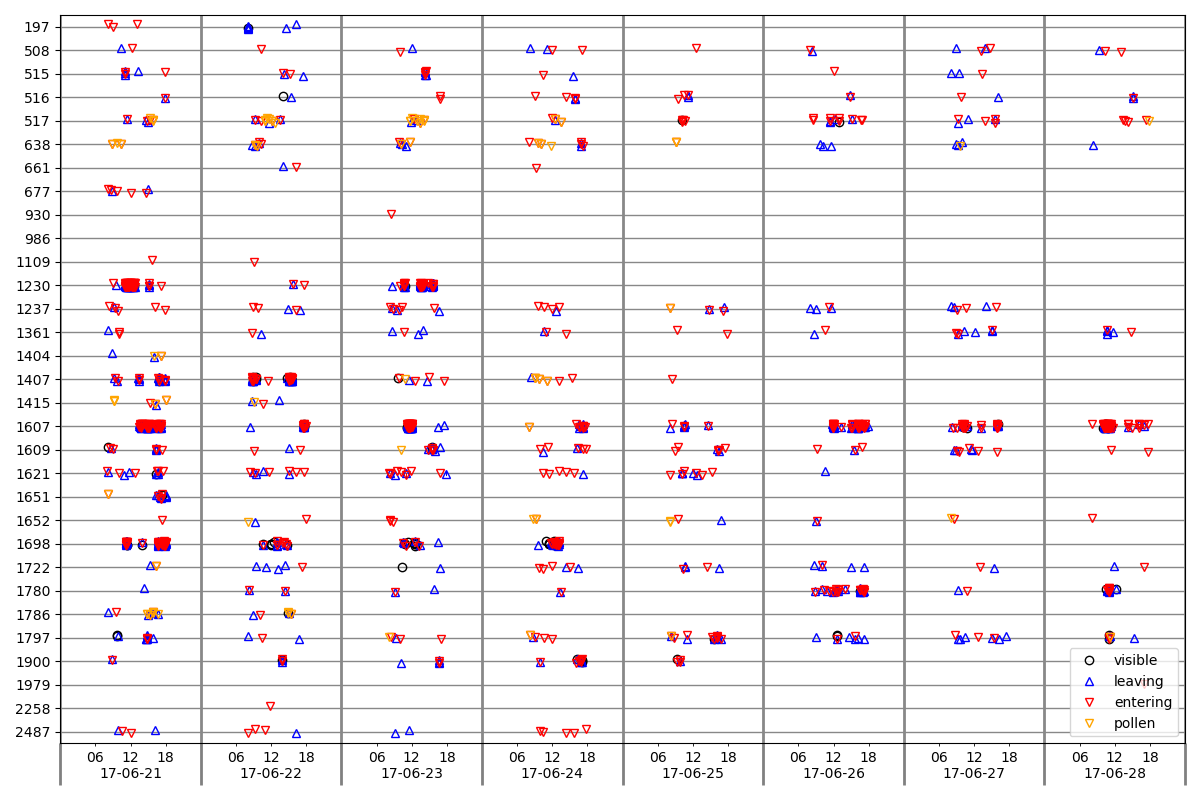

In [153]:
%matplotlib widget
from datetime import datetime as dt
from matplotlib.dates import num2date

fig,axes = plt.subplots(1,1,figsize=(12,8))
plt.sca(axes)
lb.plot_activities_df(vdf, plot_interval=True, tagids=None, leaving_symbol = '^', entering_symbol = 'v');
plt.xlim(pd.to_datetime('2017-06-21 00:00'),pd.to_datetime('2017-06-29 00:00'))
lb.format_multiday()
plt.tight_layout();

#saveme={}

def on_click(event):
    print('On_click',event)
    #saveme['event']=event
    
    # CONVERT RAW COORDINATES X,Y INTO DATETIME AND ID
    x,y = event.xdata, event.ydata
    #ts = num2date(x, tz=None)
    ts = pd.Timestamp(num2date(x)).tz_localize(None)  # avoid error "Cannot compare tz-naive and tz-aware datetime-like objects"
    ry = round(y)
    ids = axes.activity_data_['ids']
    if ( (ry>=0) and (ry < len(ids)) ):
        tagid = ids[ry]
    else:
        tagid = None
    print("ID=",tagid,"date=",ts)
    if (id is None):
        return
    
    # FIND CLOSEST EVENT FOR SELECTED ID
    # https://stackoverflow.com/questions/42264848/pandas-dataframe-how-to-query-the-closest-datetime-index
    ddf0 = vdf[vdf.track_tagid==tagid]
    ddf0 = ddf0[ ddf0.entering | ddf0.leaving | ddf0.pollen ]   # Keep only specific types of events
    #ddf = ddf0.set_index('track_starttime')
    #iloc0_idx = ddf.index.get_indexer([ts], method='nearest')
    #iloc0_idx = ddf0['track_starttime'].searchsorted(ts)
    # if (iloc0_idx==ddf0.shape[0]):
    #     print('ABORT, did not find close date')
    #     return
    iloc0_idx = (ddf0['track_starttime']-ts).abs().argsort().iloc[0]
    loc_idx = ddf0.index[iloc0_idx]
    closest_item = ddf0.iloc[iloc0_idx]
    print('Event loc=',loc_idx)
    iloc_idx = vdf.index.get_indexer([loc_idx]) # Need list of target values
    #print(closest_item)
    print('Event iloc=',iloc_idx, ' loc=',loc_idx)
    # Check Right click in output then "Show Log Console" in Jupyterlab for output
    
    # PLOT BLACK DOT FOR DEBUGGING
    axes.plot(closest_item.track_starttime, axes.activity_data_['rmap'][closest_item.track_tagid], 'k*')
    print('Event track_tagid=',closest_item.track_tagid, ' track_starttime=',closest_item.track_starttime)

click_cb_id = fig.canvas.mpl_connect('button_press_event', on_click)

ax=plt.gca()

## Visualization 

index                                                                                 3606
track_id                                                                              3606
track_pollen_score                                                                0.000543
track_shape                                                                   outside_ramp
track_event                                                                       entering
track_tagid                                                                          197.0
track_hastag                                                                          True
track_startframe                                                                      9509
track_startx                                                                          1476
track_starty                                                                           980
track_starta                                                                    355.763605

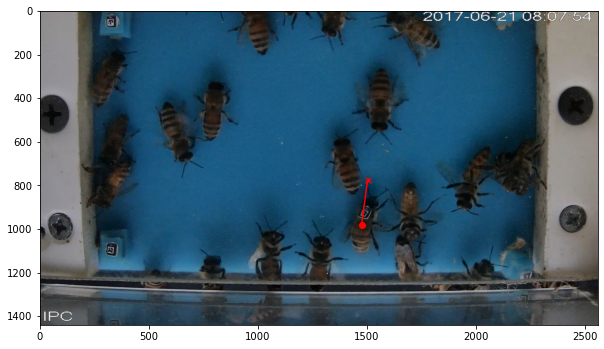

In [206]:
# Visualize one event manually
%matplotlib inline

#event = full_df.iloc[10]
event = full_df.loc[3606]

with pd.option_context('display.max_colwidth', 200):
    print(event)

fig = plt.figure(figsize=(10,6))
frame = event.track_startframe
plot_track(event, frame=frame, videoreader=None, ax=None)

In [209]:
%matplotlib widget
from ipywidgets import *
from collections import namedtuple
import time
from functools import lru_cache

# Create one figure
plt.ioff()
fig = plt.figure(figsize=(8,4))
plt.ion()
fig.canvas.header_visible = False
fig.clear()
ax = fig.add_subplot(111)
ax.clear()
ax.imshow(np.array([[0,1]]))
ax.set_title(f"Initialized")
fig.set_tight_layout(True)

from dataclasses import dataclass

@dataclass
class Glob:
    vr = None

glob = Glob()

def get_event_options(vdf, tid):
    options = list()
    for i, row in vdf[vdf.track_tagid == tid].iterrows():
        noise, name = event_name(row)
#         if not noise:
        D = dict(row)
        D['loc']=i
        options.append((name, D))
    return options

# Widgets
tids_widget = Dropdown(options = tids)
options = get_event_options(vdf, tids_widget.value)
events_widget = Dropdown(options=options)
frame_slider = widgets.IntSlider(min=0, max=10000, step=1, value=0, continuous_update=False)
scale_widget = Dropdown(options=[0,1,2,3,4,5,6])

debug_view = widgets.Output(layout=Layout(border='1px solid black', height='200px', overflow_y='auto'))
event_view = widgets.Output(layout=Layout(border='1px solid black', height='400px', max_width='600px', overflow_x='auto', overflow_y='auto'))


@lru_cache(maxsize=20)
def get_frame(frame):
    img = glob.vr[frame].asnumpy()
    glob.vr.seek(0)
    return img
        
def debug(clear_output=False):
    def wrapped_fun(fn):
        def wraps(*args, **kwargs):
            with debug_view:
                if (clear_output):
                    debug_view.clear_output()
                fn(*args, **kwargs)
        return wraps
    return wrapped_fun

@debug(clear_output=True)
def tid_changed(change):
    ctid = change.new
    print('tid_changed',ctid)
    options = get_event_options(vdf, ctid)
    events_widget.options = options

@debug()
def event_changed(change):
    event = change.new
    print('event_changed',event)
    
    eventrow = vdf.loc[event['loc']]
    
    with event_view:
        event_view.clear_output()
        with pd.option_context('display.max_colwidth', 200):
            display(pd.DataFrame(eventrow))
            print(eventrow['video_name'])

    print('LOADING VIDEO...')
    tic = time.perf_counter()
    glob.vr = VideoReader(event['video_name'], ctx=cpu(0))
    toc = time.perf_counter()
    print(f'LOADED. ({toc-tic:.2f}s)')
    glob.vr.seek(0)
    get_frame.cache_clear()
    
    ax.clear()

    #frameimg = glob.vr[0].asnumpy()
    #ax.imshow(imscale(frameimg*0, 1.0)) # Dummy
    
    frame = event["track_startframe"]
    frame_slider.min = -10000
    frame_slider.max = frame+100
    frame_slider.min = frame-100
    frame_slider.value = frame
    
    redraw()

@debug()
def frame_changed(change):
    frame = change.new
    print('frame_changed',frame)
    redraw()

@debug()
def redraw(change=None):
    event, frame = events_widget.value, frame_slider.value
    #print(event, frame)
    resolution_level = scale_widget.value
    scale = 2**resolution_level
    
    print('REDRAW', frame, resolution_level)
    loc = event['loc']
    
    #plot_track(event, frame, vr, ax)
    tic = time.perf_counter()
    frameimg = get_frame(frame)
    toc = time.perf_counter()
    print(f'TOOK {toc-tic:.2f}s')

    if len(ax.images)==0:
        ax.clear()
        ax.imshow(imscale(frameimg, 1.0/scale), extent=[0,frameimg.shape[1],frameimg.shape[0],0])
        #ax.plot([0,3],[6,4],'r-')

        # OVERLAY TRACK BEGIN/END
        start_x = event["track_startx"] 
        start_y = event["track_starty"]
        end_x = event["track_endx"]
        end_y = event["track_endy"]

        ax.plot( (start_x,end_x), (start_y,end_y), 'r.-' )
        ax.plot( (start_x,), (start_y,), 'ro' )
        ax.plot( (end_x,), (end_y,), 'rx' )
    else:
        ax.images[0].set_data( imscale(frameimg, 1.0/scale) )
    ax.set_title(f"Event {loc}, Frame {frame}")
    
    #fig.canvas.draw()
    
#interact(f, tid=tids_widget, event=events_widget, frame=frame_slider);

tids_widget.observe(tid_changed, names="value")
events_widget.observe(event_changed, names="value")
frame_slider.observe(frame_changed, names="value")
scale_widget.observe(redraw, names="value")

scene = VBox([ 
                HBox([tids_widget, events_widget]),
                HBox([frame_slider, scale_widget]),
                HBox([fig.canvas, event_view]),
                HBox([debug_view])
             ], layout=Layout(width='100%',overflow_x='auto'))
display(scene)

from traitlets.utils.bunch import Bunch
tid_changed(Bunch(new=tids[0]))
event_changed(Bunch(new=events_widget.options[0][1]))

interactive(children=(IntSlider(value=0, continuous_update=False, description='frame', max=10000), IntSlider(v…

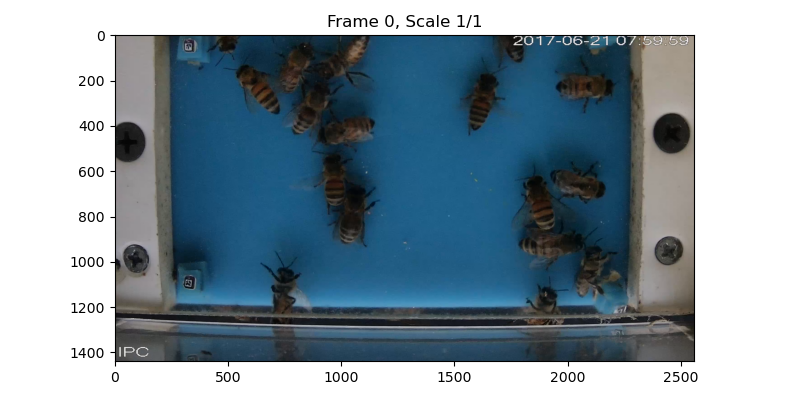

In [125]:
# Example of faster GUI to plot images
%matplotlib widget
from ipywidgets import *

from skimage.transform import resize, rescale
import PIL

def imscale(img, s):
    h,w,_ = img.shape
    return np.asarray(PIL.Image.fromarray(img).resize((int(w * s), int(h * s))))

# Pick up event to display
event = vdf.iloc[0]

# Create sliders
frame_slider = widgets.IntSlider(min=0, max=10000, step=1, value=0, continuous_update=False)
scale_slider = widgets.IntSlider(min=0, max=6, step=1, value=0, continuous_update=False)

# Open video
vr = VideoReader(event['video_name'], ctx=cpu(0))

# Create one figure for all display
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure(figsize=(8,4))
fig.set_tight_layout(True)
fig.canvas.header_visible = False
ax = fig.add_subplot(111)
# Initialize plot to set the image extent
frame=0
frameimg = vr[frame].asnumpy()
ax.clear()
ax.imshow(imscale(frameimg, 1.0))
ax.set_title(f"{frame}")

def show_frame(frame, resolution_level):
    # Load image
    frameimg = vr[frame].asnumpy()
    scale = 2**resolution_level
    frameimg = imscale(frameimg, 1.0/scale)
    
    # Alternate method: reset the whole axes
    #ax.clear()
    #ax.imshow(frameimg)
    # Replace image data (keep same axis extent)
    ax.images[0].set_data( frameimg )
    ax.set_title(f"Frame {frame}, Scale 1/{scale}")
    #fig.canvas.draw()
    
interact(show_frame, frame=frame_slider, resolution_level=scale_slider);